In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy.integrate import dblquad

# Poisson Point Processes

## Data Generation

In [13]:
def generate_poisson_points(kappa, scale, region):
    """
    Generate a Poisson Point Process in a 2D region based on intensity function.
    
    Parameters:
    - kappa (torch.Tensor): The intensity parameter (scalar or vector).
    - scale (torch.Tensor): The scale parameter (scalar or vector).
    - region (tuple): The spatial domain as ((xmin, xmax), (ymin, ymax)).
    - num_samples (int): Number of candidate points to sample for rejection sampling.
    
    Returns:
    - points (numpy.ndarray): The simulated points of the PPP.
    """
    (xmin, xmax), (ymin, ymax) = region

    area = (xmax - xmin) * (ymax - ymin)
    max_intensity = kappa * area  # Maximum value of intensity
    num_samples = np.random.poisson(lam=max_intensity)[0]

    x_candidates = np.random.uniform(xmin, xmax, size=num_samples)
    y_candidates = np.random.uniform(ymin, ymax, size=num_samples)
    candidates = torch.tensor(np.stack([x_candidates, y_candidates], axis=1), dtype=torch.float32)
    
    squared_norm = torch.sum(candidates**2, dim=-1)
    intensity = kappa * torch.exp(-squared_norm / scale**2)
    
    uniform_samples = torch.rand(num_samples)  # Uniform samples for rejection
    acceptance_mask = uniform_samples < (intensity / kappa)
    
    accepted_points = candidates[acceptance_mask]
    return accepted_points.numpy()

In [33]:
kappa = torch.tensor([10000.0])
scale = torch.tensor([0.5])

region = ((0, 1), (0, 1))  # A square domain in 2D

In [34]:
x_t = generate_poisson_points(kappa, scale, region)

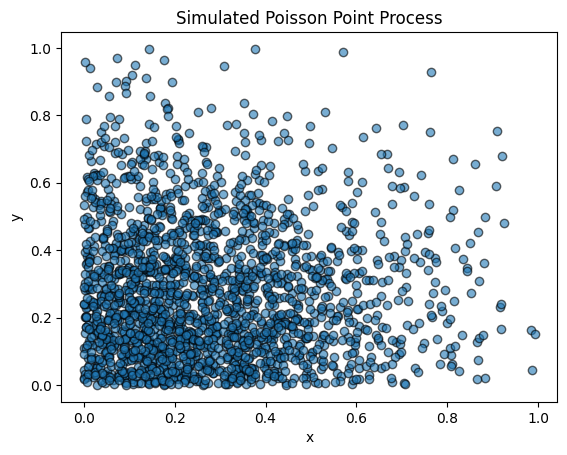

In [35]:
plt.scatter(x_t[:, 0], x_t[:, 1], alpha=0.6, edgecolor='k')
plt.title("Simulated Poisson Point Process")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Poisson Model

In [36]:
class Poisson(nn.Module):
    def __init__(self, dimensions):
        super(Poisson, self).__init__()
        # self.kappa = nn.Parameter(torch.abs(torch.randn(dimensions, dtype=torch.float64)))
        self.scale = nn.Parameter(torch.abs(torch.randn(dimensions, dtype=torch.float64)))
        
    def forward(self, x):
        squared_norm = torch.sum(x**2, dim=-1)
        return - squared_norm / self.scale**2
        # return torch.log(self.kappa) - squared_norm / self.scale**2

In [37]:
def compute_psi(x, model):
    x.requires_grad_()
    nn_output = model(x)
    psi = torch.autograd.grad(
        nn_output, x, grad_outputs=torch.ones_like(nn_output), create_graph=True)[0]
    return psi

In [38]:
def J(x_t, model):
    T = len(x_t)
    total_sum = 0
    for t in range(T):
        x = x_t[t]
        psi_x = compute_psi(x, model)

        divergence = 0
        for i in range(x.shape[-1]):
            gradient = torch.autograd.grad(
                psi_x[..., i].sum(), x, retain_graph=True, create_graph=True)[0]
            divergence += gradient[..., i]
        norm_squared = (psi_x ** 2).sum()

        total_sum += 0.5 * norm_squared + divergence
    return total_sum / T

In [39]:
def optimize_theta(
        x_t, dim, nn_model,
        num_epochs=1000, learning_rate=1e-3,
        ):
    model = nn_model(dim)
    optimizer = torch.optim.Rprop(model.parameters(), lr=learning_rate)
    losses = []
    estimated_scale = []

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        x_t_tensor = torch.tensor(x_t, dtype=torch.float64)
        loss = J(x_t_tensor, model)

        loss.backward()  
        optimizer.step()

        losses.append(loss.item())
        estimated_scale.append(model.scale.detach().numpy().copy())
        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item()}")

    return model, losses, estimated_scale

In [40]:
epochs = 50
model, losses, estimated_scale = optimize_theta(
    x_t, 1, Poisson, num_epochs=epochs, learning_rate=1e-3,
    )

Epoch 0/50, Loss: -7.4053212455518915
Epoch 1/50, Loss: -7.4411753418836
Epoch 2/50, Loss: -7.4829890153882905
Epoch 3/50, Loss: -7.5314589814944
Epoch 4/50, Loss: -7.587229289666437
Epoch 5/50, Loss: -7.650813525515492
Epoch 6/50, Loss: -7.722482789382767
Epoch 7/50, Loss: -7.802110819711701
Epoch 8/50, Loss: -7.888968397414304
Epoch 9/50, Loss: -7.98146239424046
Epoch 10/50, Loss: -8.076822018947828
Epoch 11/50, Loss: -8.17074770708162
Epoch 12/50, Loss: -8.25705817452937
Epoch 13/50, Loss: -8.327398633313893
Epoch 14/50, Loss: -8.37110539480193
Epoch 15/50, Loss: -8.375351515684718
Epoch 16/50, Loss: -8.375351515684718
Epoch 17/50, Loss: -8.379133612949866
Epoch 18/50, Loss: -8.379133612949866
Epoch 19/50, Loss: -8.378632900976204
Epoch 20/50, Loss: -8.378632900976204
Epoch 21/50, Loss: -8.379241218611511
Epoch 22/50, Loss: -8.379024301580644
Epoch 23/50, Loss: -8.379024301580644
Epoch 24/50, Loss: -8.37926392725462
Epoch 25/50, Loss: -8.379205604044115
Epoch 26/50, Loss: -8.3792056

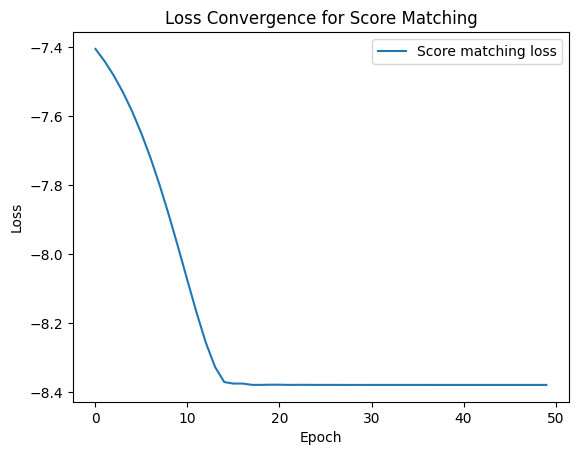

In [41]:
plt.plot(losses, label="Score matching loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Convergence for Score Matching')
plt.legend()
plt.show()


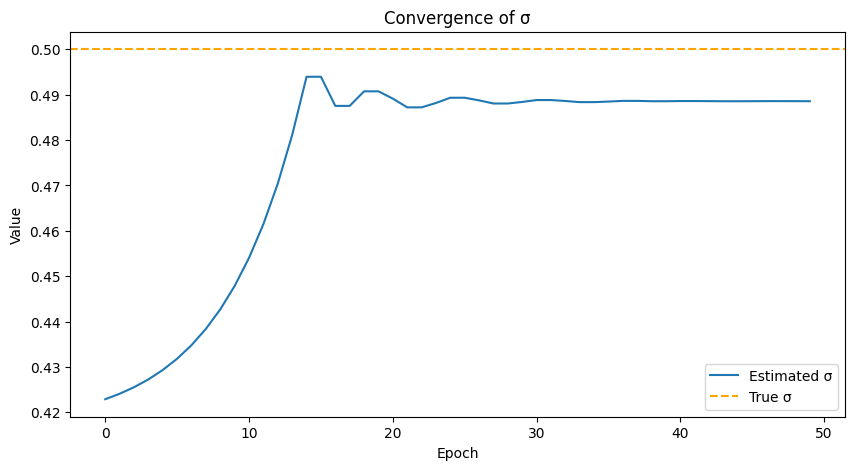

In [42]:
# plt.figure(figsize=(10, 5))
# plt.plot(estimated_kappa, label="Estimated κ")
# plt.axhline(kappa[0], color='orange', linestyle='--', label="True κ")
# plt.xlabel('Epoch')
# plt.ylabel('Value')
# plt.legend()
# plt.title('Convergence of κ')
# plt.show()

plt.figure(figsize=(10, 5))
plt.plot(estimated_scale, label="Estimated σ")
plt.axhline(scale[0], color='orange', linestyle='--', label="True σ")
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Convergence of σ')
plt.show()

In [43]:
# print("Estimated kappa:", model.kappa)
# print("True kappa:", kappa)
print("Estimated scale:", model.scale)
print("True scale:", scale)

Estimated scale: Parameter containing:
tensor([0.4886], dtype=torch.float64, requires_grad=True)
True scale: tensor([0.5000])


In [44]:
def infer_kappa(x_t, sigma, region):
    """
    Infers the parameter kappa for the Poisson Point Process intensity function
    given the data x_t and the known scale parameter sigma.
    
    Args:
    - x_t: numpy array of shape (n, d), where n is the number of data points and d is the dimension of the data.
    - sigma: the known scale parameter (positive real number).
    
    Returns:
    - kappa: the inferred scaling factor for the intensity function.
    """
    (a1, b1), (a2, b2) = region
    n = len(x_t)
    
    def integrand(x0, x1, sigma):
        return np.exp(-(x0**2 + x1**2) / sigma**2)

    integral_result, _ = dblquad(integrand, a1, b1, lambda x0: a2, lambda x0: b2, args=(sigma,))
    
    kappa = n / integral_result
    return kappa

In [45]:
kappa = infer_kappa(x_t, estimated_scale[-1][0], region)
print(f"Inferred kappa: {kappa}")

Inferred kappa: 10594.46239980586
